<a href="https://colab.research.google.com/github/lkarjun/malayalam-language-model/blob/main/Malayalam-Language-Model/malayalam-language-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Downloading

In [5]:
!pip install -qq dvc[gdrive]

!dvc get https://github.com/lkarjun/malayalam-language-model \
Datasets/

!unzip -q 'Datasets/*.zip' -d Datasets/

     |████████████████████████████████| 401 kB 5.1 MB/s 
     |████████████████████████████████| 217 kB 43.2 MB/s 
     |████████████████████████████████| 48 kB 5.0 MB/s 
     |████████████████████████████████| 44 kB 2.9 MB/s 
     |████████████████████████████████| 109 kB 53.6 MB/s 
     |████████████████████████████████| 41 kB 44 kB/s 
     |████████████████████████████████| 280 kB 47.5 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 287 kB 44.2 MB/s 
     |████████████████████████████████| 180 kB 50.8 MB/s 
     |████████████████████████████████| 4.5 MB 42.9 MB/s 
     |████████████████████████████████| 548 kB 51.6 MB/s 
     |████████████████████████████████| 3.6 MB 36.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 229 kB 51.9 MB/s 
     |████████████████████████

## Malayalam Language Model

### Imports

In [2]:
!pip install -qq fastai==2.5.3 transformers tokenizers ohmeow-blurr

     |████████████████████████████████| 189 kB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 24.5 MB/s 
     |████████████████████████████████| 6.8 MB 36.2 MB/s 
     |████████████████████████████████| 91 kB 9.5 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 47.0 MB/s 
     |████████████████████████████████| 895 kB 42.1 MB/s 
     |████████████████████████████████| 1.2 MB 49.5 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 311 kB 40.8 MB/s 
     |████████████████████████████████| 243 kB 47.9 MB/s 
     |████████████████████████████████| 1.1 MB 51.2 MB/s 
     |████████████████████████████████| 133 kB 54.4 MB/s 
     |████████████████████████████████| 271 kB 51.5 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 51.3 MB/s 


In [ ]:
!huggingface-cli login

In [1]:
from fastai.text.all import *
from transformers import PreTrainedTokenizerFast
from transformers import BertLMHeadModel, BertConfig
from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

import pandas as pd
from tqdm import tqdm

DATASET = Path("/content/Datasets/")

tqdm.pandas(colour = 'red')

In [13]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("lkarjun/malayalam-language-model", 
                                                    use_auth_token=True,
                                                    )

Downloading:   0%|          | 0.00/158 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

### Dataset Loading

In [2]:
def open_text_files(f: str):
  return Path(f).read_text(encoding="utf-8")

In [6]:
files = ['article_files.csv', 'magazine_files.csv', 'wikitext_files.csv']
df = pd.concat([pd.read_csv(DATASET/f) for f in files], ignore_index = True)

In [7]:
df['content'] = df['file_path'].progress_apply(open_text_files)

100%|██████████| 35490/35490 [00:03<00:00, 10191.83it/s]


In [9]:
sample = df.iloc[:20]
len(sample)

20

### Model Config

Default Bert Config 

( vocab_size = 30522 hidden_size = 768 num_hidden_layers = 12 num_attention_heads = 12 intermediate_size = 3072 hidden_act = 'gelu' hidden_dropout_prob = 0.1 attention_probs_dropout_prob = 0.1 max_position_embeddings = 512 type_vocab_size = 2 initializer_range = 0.02 layer_norm_eps = 1e-12 pad_token_id = 0 position_embedding_type = 'absolute'use_cache = Truec lassifier_dropout = None **kwargs )

In [14]:
CONFIG = BertConfig(
            vocab_size=tokenizer.vocab_size,
            pad_token_id=tokenizer.pad_token_id,
            is_decoder=True,
            name_or_path = "lkarjun/malayalam-language-model",
            )


In [15]:
LModel = BertLMHeadModel(CONFIG)

### Custom Transforms

In [17]:
class MalayalamTokenizer(Transform):
  
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer
  
  def encodes(self, x):
    toks = self.tokenizer.tokenize(x)
    toks = self.tokenizer.convert_tokens_to_ids(toks)
    return tensor(toks)

  def decodes(self, x):
    text = self.tokenizer.decode(x.cpu().numpy())
    text = TitledStr(text)
    return text

### Dataloder

In [57]:
train_bs, val_bs, train_sl, val_sl = 200, 256, 250, 300

In [19]:
splits = RandomSplitter(valid_pct=.1, seed=7)(df['content'])

In [20]:
Mltokenizer = MalayalamTokenizer(tokenizer)

In [21]:
Mltransforms = TfmdLists(
                    df['content'], 
                    Mltokenizer, 
                    splits = splits,
                    dl_type = LMDataLoader
                  )

In [22]:
Mdls = Mltransforms.dataloaders(bs = train_bs, 
                                val_bs = val_bs,
                                seq_len = train_sl,
                                val_seq_len = val_sl)

In [23]:
Mdls.train.show_batch(dataloader = Mdls)

,text,text_
0,എള്ള ##ിനെക്കുറിച്ച് അറിയുന്ന ##തിന ##േക്കാള ##േറെ നമുക്ക് എണ്ണയ ##െക്ക ##ുറ ##ിച്ച് അറിയാം.'എള ##്‍ നെയ്യ്'ആണ് എണ്ണ,##ിനെക്കുറിച്ച് അറിയുന്ന ##തിന ##േക്കാള ##േറെ നമുക്ക് എണ്ണയ ##െക്ക ##ുറ ##ിച്ച് അറിയാം.'എള ##്‍ നെയ്യ്'ആണ് എണ്ണ.
1,ചില മരുന്നുകള്‍ കഴിക്കുന്നതും മുടികൊഴിച്ച ##ിലിന് കാരണമാകാം. ഹോര്‍മോണ്‍ പ്രശ്നങ്ങള്‍ മൂലമുള്ള മുടികൊഴിച്ച ##ില്‍ സങ്കീര്‍ ##മാണ്. ഇവിടെ മുടിയുടെ വളര്‍ച്ചാ ##സമയം ഗണ്യമായി,മരുന്നുകള്‍ കഴിക്കുന്നതും മുടികൊഴിച്ച ##ിലിന് കാരണമാകാം. ഹോര്‍മോണ്‍ പ്രശ്നങ്ങള്‍ മൂലമുള്ള മുടികൊഴിച്ച ##ില്‍ സങ്കീര്‍ ##മാണ്. ഇവിടെ മുടിയുടെ വളര്‍ച്ചാ ##സമയം ഗണ്യമായി കുറയുന്നു


In [24]:
Mdls.valid.show_batch(dataloader = Mdls, max_n = 1)

,text,text_
0,"ആയുസ്സ് കൂടുന്നത് നല്ല കാര്യമാണ്. പക്ഷേ, അതുകൊണ്ട് മാത്രമായി ##ല്ല. അതിന്റെ ഗുണ ##ഫലം കിട്ട ##ണമെങ്കില്‍ വാര്‍ധക്യ ##ത്തില്‍ ശാരീരികവും മാനസികവുമായ ആരോഗ്യം നിലനിര്‍ത്താന്‍ കഴിയണം. വാര്‍ധക്യ ##ം ആനന്ദ ##കരമായി ##രിക്ക ##ണം. അതിന്","കൂടുന്നത് നല്ല കാര്യമാണ്. പക്ഷേ, അതുകൊണ്ട് മാത്രമായി ##ല്ല. അതിന്റെ ഗുണ ##ഫലം കിട്ട ##ണമെങ്കില്‍ വാര്‍ധക്യ ##ത്തില്‍ ശാരീരികവും മാനസികവുമായ ആരോഗ്യം നിലനിര്‍ത്താന്‍ കഴിയണം. വാര്‍ധക്യ ##ം ആനന്ദ ##കരമായി ##രിക്ക ##ണം. അതിന് സാധിക്കുന്നു"


### Fix Hugging Face Output

In [25]:
class FixHFOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

### Model Training

In [26]:
learn = Learner(Mdls, LModel, 
                loss_func=CrossEntropyLossFlat(), 
                cbs = [FixHFOutput],
                metrics=Perplexity()).to_fp16()

In [27]:
learn.validate()

(#2) [11.378555297851562,87426.640625]

SuggestedLRs(minimum=0.0009120108559727668, steep=0.0003981071640737355, valley=0.00010964782268274575, slide=0.005248074419796467)

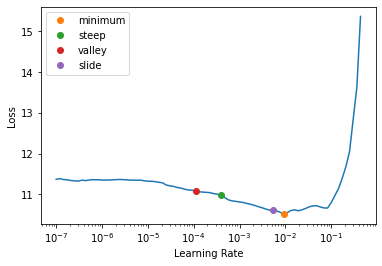

In [28]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])